# Mid-semester assignment - Reinforcement Learning 

---
<br>

### Name and ID:
Student 1: Ron Darmon, XXXXXXXXX
<br>
Student 2: Roei Arpaly, XXXXXXXXX

---

## General

#### Installs

In [1]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install -U kaleido
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1FeuIx5OVLmfCx0dxxwU-7Xn8gpPc-53D
!unzip /content/maze_mid.zip

In [2]:
!gdown 1S7IptEW6yqnVAHgdg8swb2SN73xqXLHN  # gdown to the explainer.md file of this notebook

Downloading...
From: https://drive.google.com/uc?id=1S7IptEW6yqnVAHgdg8swb2SN73xqXLHN
To: /content/explainer.md
100% 1.14k/1.14k [00:00<00:00, 4.13MB/s]


#### Imports

In [3]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
from maze_mid import *
from maze_mid.cust_maze import MazeEnvCast5x5, MazeEnvCast15x15, MazeEnvCast25x25
import pyvirtualdisplay
import imageio
import IPython
import time
from google.colab import drive


# Viz libraries
import pandas as pd
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

color_palette = ['#294987', '#ff947c', '#5a1038', '#38a19b', '#764173', '#6e6e6e', '#b2947c', '#192d54', '#a31e67', '#a16154', '#807b68', '#ffb919']
tab10 = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

#### Utils


In [4]:
# Mount drive
drive_path = '/content/gdrive'
drive_saving_path = '/content/gdrive/My Drive/RL/Midterm_proj'
drive.mount(drive_path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead



Mounted at /content/gdrive


The cell below contains the video display configuration

In [5]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [6]:
def save_mp4_to_drive(filename):
  video = open(filename, 'rb').read()
  with open(f'{drive_saving_path}/{filename}', 'wb') as f:
    f.write(video)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



The next cell holds a function that verifies which actions are available from your current state and a mapping from actions to logical names, directions and movements.

In [7]:
# Numbers to action mapping.
nTa = {
       0: ("UP", "N", (0, -1)),
       1: ("DOWN", "S", (0, 1)),
       2: ("RIGHT", "E", (1, 0)),
       3: ("LEFT", "W", (-1, 0))
       }

def get_available_actions(env, state, actions):
    available_actions = []
    for action in actions:
        # Get the correct letter of the action
        action_letter = nTa[action][1]
        
        # Check if the move is legit
        legit = env.unwrapped.maze_view.maze.is_open(state, action_letter)
        if(legit):
          available_actions.append(action)

    return available_actions

Example of a wrapper class that will help us do customization for the environment called "taxi".

In [8]:
def plot_env(env):
  env.reset()
  plt.imshow(env.render('rgb_array'))
  state_size = env.observation_space
  a = env.action_space 
  state = env.reset()
  env.render()
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)
  env.render()
  print(f'action: {action}, observation: {observation},  reward: {reward}, done: {done}')

In [9]:
def create_video_random_walk(env, video_filename='imageio.mp4'):

  start_time = time.time()
  done = False
  iter = 0
  with imageio.get_writer(video_filename, fps=10) as video:
    while (iter < 10) or not done:
      time_passed = int(time.time() - start_time)
      if done or time_passed > 3:
        break
      iter +=1
      action = env.action_space.sample()
      observation, reward, done, info = env.step(action)
      video.append_data(env.render(mode='rgb_array'))
      
  return embed_mp4(video_filename)

---

#### Additional Utils

In [10]:
def viz_rewards(rewards_list, title, rolling=True, sliding_window=20):
    """
    Visualize the rewards of an algorithm over episodes.
    
    Parameters
    ----------
    rewards_list: list[tuple[dict[str, int], list[float]]]
        A list of tuples, where each tuple contains a dictionary of parameters and a list of rewards.
    title: str
        The name of the graph.
    rolling: bool, optional
        Whether to apply rolling mean to smooth the rewards.
    sliding_window: int, optional
        The window size for the rolling mean. Only used if `rolling` is True.
        
    Returns
    -------
    plotly.graph_objs._figure.Figure
        A plotly Figure object containing the reward plot.
    """
    
    fig = go.Figure()
    
    for params, rewards in rewards_list:
      
      if rolling:
        rewards = pd.Series(rewards).rolling(window=sliding_window).mean()

      fig.add_trace(go.Scatter(x=np.arange(len(rewards)),
                              y=rewards,
                              mode='lines',
                              name=', '.join([f'{key}: {params[key]}' for key in params]),
                              hovertemplate='%{y:.3f}'
                              )
        )

    # Define the layout of the plot
    fig.update_layout(title=dict(text=title, x=0.5, y=0.85),
                      xaxis=dict(title='Episode Number', dtick=25),
                      yaxis=dict(title='Reward'),
                      legend=dict(orientation="v", title='Params'),
                      height=500, width=1200, template="plotly_white",
                      hovermode="x unified")
    
    fig.show(config=dict(displayModeBar=False), renderer='png')

In [11]:
def viz_heatmap(matrix, title, name=None):
    """
    Visualize a heatmap of a matrix.
    
    Parameters
    ----------
    matrix: numpy.ndarray
        A 2D array to visualize as a heatmap.
    title: str
        The title of the heatmap.
    name: str, optional
        The name to display in the legend.
    
    Returns
    -------
    plotly.graph_objs._figure.Figure
        A plotly Figure object containing the heatmap.
    """

    fig = go.Figure(data=go.Heatmap(z=matrix.T,
                                    text=matrix.T,
                                    texttemplate="%{text}",
                                    hovertemplate="State: (%{y},%{x})<br>Visits: %{z}",
                                    name=name,
                                    colorscale='RdBu_r',
                                    textfont=dict(size=6),
                                    showscale=False
                                    ))

    fig.update_layout(title=dict(text=title, x=0.5, y=0.9),
                      xaxis=dict(dtick=1),
                      yaxis=dict(autorange="reversed", dtick=1),
                      height=700, width=700, template="plotly_white")
      
    fig.show(config=dict(displayModeBar=False), renderer='png')

In [12]:
import itertools

def grid_search(param_grid, func, env, reward_threshold=0.985, sliding_window=20):
    """
    Search for the optimal combination of hyperparameters for a given function by evaluating the function
    over a grid of parameter combinations.
    
    Parameters
    ----------
    param_grid: dict[str, list[int]]
        A dictionary mapping parameter names to lists of possible values.
    func: callable
        The function to optimize. The function should take a dictionary of keyword arguments, where the keys
        are the parameter names and the values are the parameter values.
    env: gym.Env
        An OpenAI gym environment.
    reward_threshold: float, optional
        The minimum average reward required for a parameter combination to be considered optimal.
    sliding_window: int, optional
        The window size for the rolling mean used to smooth the rewards.
    
    Returns
    -------
    list[tuple[dict[str, int], list[float]]]
        A list of tuples, where each tuple contains a dictionary of parameters and a list of rewards.
    dict[str, int]
        A dictionary of the optimal parameter combination.
    int
        The number of episodes required to reach the reward threshold.
    """
    n_parameters = len(param_grid)
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    rewards_list = []
    best_params, min_episode = None, 500
    for params in all_params:
        print('\n', params)

        π, rewards = func(env=EnvWrapper(config=dict(stochastic=0.1), env=env), max_episodes=500, display_rewards=True, **params)
        rewards_list.append((params, rewards))

        rewards = pd.Series(rewards).rolling(window=sliding_window).mean().fillna(0)
        episode = np.argmax(np.where(rewards > reward_threshold, 0, rewards))

        if episode < min_episode:
            min_episode = episode
            best_params = params

    return rewards_list, best_params, min_episode

---

## EX1

### Random actions video 5X5

In [13]:
create_video_random_walk(env=MazeEnvCast5x5())

/usr/local/lib/python3.10/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



---

### Dynamic Programming 5X5

In [14]:
def create_game_environment(env):
    # Initialize the environment
    env = env()

    # Number of states
    number_of_states = np.prod((env.observation_space.high - env.observation_space.low) + 1 )

    # Define the initial state
    initial_state = (env.observation_space.low[0], env.observation_space.low[1])

    # Define the terminal state
    terminal_state = (env.observation_space.high[0], env.observation_space.high[1])

    # Available Actions
    actions = np.arange(env.action_space.n)

    # Maze rows and cols
    rows, cols = env.observation_space.high[0] + 1, env.observation_space.high[1] + 1

    # Create the Maze
    maze = env.unwrapped.maze_view.maze.maze_cells

    return env, number_of_states, initial_state, terminal_state, actions, rows, cols, maze

In [15]:
def create_transition_probability(env, actions, rows, cols, R, p=0.9):

    # Create a placeholder for the model P which mimics env.P
    P = {}
    for i in range(rows):
        for j in range(cols):
                P[(i,j)] = {action: [] for action in actions}
                
    states = list(P.keys())

    # Create the model
    for state in states:
        # Get the available actions (legit actions)
        legit_actions = get_available_actions(env, state, actions)

        # Get the states
        next_states = []
        # The action the agent chose
        for chosen_action in actions:
            # The action the agent actually takes
            for actual_action in actions:
                
                # Find out if youre staying in place or actually moving
                moving_direction = nTa[actual_action][2]
                next_state = tuple(np.add(state, moving_direction)) if actual_action in legit_actions else state

                # Append the transition model
                if actual_action == chosen_action:
                    P[state][chosen_action].append([p, next_state, R[next_state], 0])  # probaility, next state, reward, done
                else:
                    P[state][chosen_action].append([(1 - p) / (actions.shape[0] - 1), next_state, R[next_state], 0])

    π = {state: np.ones_like(actions) / len(actions) for state in P.keys()}
    
    return P, π, states, p

In [16]:
def stochastic_transition(selected_action):
    """

    
    Returns a random action according to a stochastic transition probability distribution.
    
    Parameters
    ----------
    selected_action : int
        The action that is most likely to be chosen.
    
    Returns
    -------
    action : int
        A randomly chosen action according to the probability distribution.
    """
    
    dist = {action: (1 - p) / (actions.shape[0] - 1) for action in actions}
    dist[selected_action] = p

    return random.choices(actions, dist.values())

In [17]:
def compute_action_value(policy, π, actions, state, terminal_state, V, discount):
    """

    Compute the action value for a given state and policy.

    Parameters
    ----------
    - policy (dict): A mapping of states to actions and their corresponding transition probabilities.
    - π (dict): A mapping of states to action probabilities.
    - state (tuple): The current state.
    - V (dict): A mapping of states to their values.
    - discount (float): The discount factor, also known as gamma.

    Returns
    ----------
    - value (float): The action value for the given state and policy.
    """

    value = 0
    for action in actions:
        action_probability = π[state][action]
        for transition in policy[state][action]:

            if state == terminal_state:
              continue

            transition_probability, next_state, reward, done = transition
            if action_probability != 0:
                value += action_probability * (transition_probability * (reward + (discount * V[next_state])))

    return value

In [18]:
def compute_π(action, size, epsilon):
    actions = np.eye(size) * (1 - epsilon - (epsilon / (size - 1)))
    epsilon_actions = np.zeros_like(actions) + (epsilon / (size - 1))
    return (actions + epsilon_actions)[action]

In [19]:
def policy_evaluation(maze, policy, π, actions, states, terminal_state, discount, epsilon, n_iters=1000):
    """
    
    Evaluate a given policy using policy iteration.
    
    Parameters
    ----------
    policy : array-like
        An array representing the policy to be evaluated. It should have the same shape as the maze array.
    π : float
        The probability of choosing a random action.
    discount : float
        The discount factor for future rewards.
    epsilon : float, optional
        The convergence threshold. The function will stop iterating when the change in the value function is below this threshold.
    n_iters : int, optional
        The maximum number of iterations to run before stopping.
    
    Returns
    -------
    V : array-like
        The value function for the given policy, with the same shape as the maze array.
    
    """
    V = np.zeros_like(maze, dtype=np.float64)

    for _ in range(n_iters):
        delta = 0
        for state in states:
          
            initial_value = V[state]
            value = compute_action_value(policy, π, actions, state, terminal_state, V, discount)

            delta = max(delta, np.abs(value - initial_value))
            V[state] = value
        
        if delta < epsilon:
            break

    return V

In [20]:
def policy_improvement(policy, actions, states, π, V, discount, epsilon):
    """
    
    Improve a policy using policy improvement.
    
    Parameters
    ----------
    policy : array-like
        An array representing the policy to be improved. It should have the same shape as the maze array.
    π : float
        The probability of choosing a random action.
    V : array-like
        The value function for the given policy, with the same shape as the maze array.
    discount : float
        The discount factor for future rewards.
    
    Returns
    -------
    new_π : array-like
        An improved version of the input policy. It has the same shape as the maze array.
    
    """

    new_π = π.copy()  # Avoid assigning new values on the initial π
    for state in states:

        action_values = np.zeros(len(actions))
        for action in actions:

            action_probability = new_π[state][action]
            if action_probability != 0:
            
              for transition in policy[state][action]:
                  transition_probability, next_state, reward, done = transition
                  
                  action_values[action] += transition_probability * ((reward + done) + (discount * V[next_state]))

        best_action = np.argmax(action_values)
        new_π[state] = compute_π(best_action, size=len(actions), epsilon=epsilon)

    return new_π

In [21]:
def policy_iteration(env, discount=0.9, epsilon=1e-10, n_iters=10):
    """
    
    Iteratively improve a policy using policy evaluation and policy improvement.
    
    Parameters
    ----------
    discount : float, optional
        The discount factor for future rewards.
    n_iters : int, optional
        The maximum number of iterations to run before stopping.
    
    Returns
    -------
    new_π : array-like
        The improved policy. It has the same shape as the maze array.
    V : array-like
        The value function for the improved policy, with the same shape as the maze array.
    
    """

    # SETUP:
    env, number_of_states, initial_state, terminal_state, actions, rows, cols, maze = create_game_environment(env=env)
  
    # Initialize R - The rewards, using the above formula
    R = np.ones_like(maze, dtype=float) * (-0.1 / number_of_states)
    R[terminal_state] = 1

    P, π, states, p = create_transition_probability(env=env, actions=actions, rows=rows, cols=cols, R=R)

    # A policy is indexed by a state and action and returns a probability of
    # executing that action in that state.

    # STEP 1: Create Inital policy
    init_π = {state: np.ones_like(actions) / len(actions) for state in P.keys()}

    policy_stable = False

    # STEP 2: Policy Iteration:
    for _ in range(n_iters):

        # STEP 2.1: Policy Evalution
        V = policy_evaluation(maze=maze, policy=P, π=init_π, actions=actions, states=states, terminal_state=terminal_state, discount=discount, epsilon=epsilon)

        # STEP 2.2: Policy Improvement
        new_π = policy_improvement(policy=P, actions=actions, states=states, π=init_π, V=V, discount=discount, epsilon=epsilon)
        policy_stable = np.array_equal(np.array(list(new_π.values())), np.array(list(init_π.values())))
        init_π = new_π.copy()
        
        if policy_stable:
            break

    return new_π, V

In [22]:
class EnvWrapper(gym.Env):
    def __init__(self, config, env, planted_rewards_config=None):
        self.env = env()  # The wrapper encapsulates and initialize the gym env
        self.actions = np.arange(self.env.action_space.n)
        self.planted_rewards_config = planted_rewards_config
        self.config = config
    
    def step(self, action, state):
      """ This method can modify a rewards / stochastic transition """
      # obs, reward, done, info = self.env.step(action)   # calls the gym env methods
      # obs = self._blur(action, state) # applies your specific treatment
      return self._blur(action, state)

    def reset(self):
      initial_state = self.env.reset()    # same for reset
      return tuple(initial_state)

    def render(self, mode):
      return self.env.render(mode)

    def observation_space(self):
      return self.env.observation_space

    def action_space(self):
      return self.env.action_space
    

    def _blur(self, action, state):
      if np.random.random() < self.config.get('stochastic', 0.1):
        action = random.choices(np.delete(self.actions, action))[0]

      next_state, reward, done, info = self.env.step(int(action))
      
      if self.planted_rewards_config:
        if self.planted_rewards_config['negative']['position'] == state:
          reward = self.planted_rewards_config['negative']['reward']
        if self.planted_rewards_config['positive']['position'] == state:
          reward = self.planted_rewards_config['positive']['reward']

      return tuple(next_state), reward, done, info

In [23]:
def create_video(π, env, video_filename='imageio.mp4', n_iters=100):
  
  done = False
  initial_state = env.reset()
  with imageio.get_writer(video_filename, fps=10) as video:
    # Just for staying at the initial position at the first frame
    state = initial_state
    video.append_data(env.render(mode='rgb_array'))
    for _ in range(n_iters):
      action = int(np.argmax(π[state]))
      state, reward, done, info = env.step(action, state)
      video.append_data(env.render(mode='rgb_array'))

      if done:
          break
  
  env.close()
  return embed_mp4(video_filename)

 The Rewards formula: $- \frac{0.1}{number of cells} $

In [24]:
new_π, V = policy_iteration(env=MazeEnvCast5x5)

In [25]:
create_video(π=new_π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast5x5))

---

## EX2

### Dynamic Programming 15X15

In [26]:
new_π, V = policy_iteration(env=MazeEnvCast15x15, discount=0.9)

In [27]:
create_video(π=new_π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))

---

### Monte Carlo 15X15


1. Initialize the maze and the starting position, as well as the epsilon value (a small probability that controls the balance between exploration and exploitation).
2. At each step, choose a random direction to move in with probability epsilon, or choose the direction that leads to the cell with the highest probability of being reached (calculated using the data from previous random walks) with probability 1 - epsilon. If the chosen direction leads to a wall or an already visited cell, stay in the current cell.
3. Keep track of the number of steps taken and the positions visited.
4. Repeat the process a large number of times (e.g. 10,000 times).
5. After the random walker has completed all the walks, use the data collected to determine the most efficient path through the maze.

In [28]:
from collections import defaultdict

def monte_setup(env):
  """
  
  Set up the variables for the Monte Carlo method.

  Parameters
  ----------
  env : gym.Env
    The environment to set up the variables for.

  Returns
  -------
  policy : dict[int, list[float]]
    The initial policy, represented as a dictionary mapping states to a list of probabilities for each action.
  N : dict[int, numpy.ndarray]
    The N-values for each state-action pair, represented as a dictionary mapping states to arrays of N-values for each action.
  Q : dict[int, numpy.ndarray]
    The Q-values for each state-action pair, represented as a dictionary mapping states to arrays of Q-values for each action.
  valid_episodes_counter : [int]
    The number of valid episodes encountered so far.
  acc_rewards : list[float]
    The list of rewards for each valid episode encountered so far.
  episode_lens : list[int]
    The list of lengths for each valid episode encountered so far.
  n_moves : [int]
    The number of actions available in the environment.
  """

  action_space = env.action_space()
  n_moves = action_space.n

  # If value doesn't exist, use the default
  policy = defaultdict(lambda: np.ones(n_moves) * (1 / n_moves))
  N = defaultdict(lambda: np.zeros(n_moves))
  Q = defaultdict(lambda: np.zeros(n_moves))

  valid_episodes_counter = 0
  acc_rewards = []
  episode_lens = []

  return policy, N, Q, valid_episodes_counter, acc_rewards, episode_lens, n_moves

In [29]:
def generate_episode(env, n_actions, policy):
  """Generate a single episode by interacting with the given environment.

  Parameters
  ----------
  env : gym.Env
    The environment to generate the episode in.
  n_actions : int
    The number of actions available in the environment.
  policy : dict[int, list[float]]
    The policy to use for generating the episode, represented as a dictionary mapping states to a list of probabilities for each action.

  Returns
  -------
  episode : list[tuple[int, int, float]]
    The episode, represented as a list of tuples containing the state, action, and reward at each step.
  first_arrived : dict[tuple[int, int], int]
    A dictionary mapping state-action pairs to the first time the pair was encountered in the episode.
  done : bool
    Whether the episode is done.
  """

  done = False
  episode_counter = 0
  episode = []

  state = env.reset()  # initial_state (0,0)

  first_arrived = {}
  while not done:
    
    # Choose an action by its probabiliy to do some exploration in the epsilon-greedy method
    action = np.random.choice(n_actions, p=policy[state])
    next_state, reward, done, info = env.step(action, state)

    if (state, action) not in first_arrived:
      first_arrived[(state, action)] = episode_counter
    
    episode_counter += 1
    episode.append((state, action, reward))
    state = next_state

    if done:
      return episode, first_arrived, done

    if episode_counter > 10_000:
      return episode, first_arrived, done

In [30]:
def monte_carlo(env, discount=0.9, epsilon=0.3, epsilon_decay=True, epsilon_decay_coef=0.99, decay_delta=20, every_visit=False, max_episodes=500, display_rewards=False):
  """Use the Monte Carlo method to learn a policy for the given environment.

  Parameters
  ----------
  env : gym.Env
      The environment to learn the policy for.
  discount : float, optional, default: 0.9
      The discount factor to use for the Monte Carlo method, between 0 and 1.
  epsilon : float, optional, default: 0.3
      The exploration rate to use for the Monte Carlo method, between 0 and 1.
  epsilon_decay : bool, optional, default: True
      Whether to decay the exploration rate over time.
  epsilon_decay_coef : float, optional, default: 0.99
      The decay coefficient to use for the exploration rate, between 0 and 1.
  decay_delta : int, optional, default: 20
      The number of episodes to skip before decaying the exploration rate.
  every_visit : bool, optional, default: False
      Whether to use the every-visit Monte Carlo method.
  max_episodes : int, optional, default: 500
      The maximum number of episodes to run the Monte Carlo method for.
  display_rewards : bool, optional, default: False
      Whether to display the rewards of each episode.

  Returns
  -------
  policy : dict[int, list[float]]
      The learned policy, represented as a dictionary mapping states to a list of probabilities for each action.
  rewards_list : list[float]
      The list of rewards for each episode, if `display_rewards` is True. Otherwise, an empty list.
  """

  n_actions = env.action_space().n

  policy, N, Q, valid_episodes_counter, acc_rewards, episode_lens, n_moves = monte_setup(env)

  rewards_list = []

  for i_episode in np.arange(max_episodes) + 1:
    episode, first_arrived, done = generate_episode(env=env, n_actions=n_actions, policy=policy)

    total_reward = 0

    if done:
      valid_episodes_counter += 1

      states, actions, rewards = zip(*episode)
      total_rewards_episode, total_actions_episode = sum(rewards), len(actions)
      acc_rewards.append(total_rewards_episode)
      episode_lens.append(total_actions_episode)
      
      G = 0
      for reversed_step in reversed(range(total_actions_episode)):

        state, action, reward = states[reversed_step], actions[reversed_step], rewards[reversed_step]
        G = G * discount + reward

        total_reward += reward
        if first_arrived[(state, action)] == reversed_step or every_visit:

          N[state][action] += 1

          # Q-learning update rule:
          Q[state][action] = Q[state][action] + (G - Q[state][action]) / N[state][action]

          best_action = np.argmax(Q[state])
          policy[state] = [1 - epsilon + (epsilon / n_moves) if move == best_action else epsilon / n_moves  for move in range(n_moves)]

      print(f'\rEpisode {i_episode}, episodes average len: {int(np.mean(episode_lens))}', end='')

      if epsilon_decay and np.mod(valid_episodes_counter, decay_delta) == 0:
        epsilon *= epsilon_decay_coef

      rewards_list.append(total_reward)

    else:  # episode is not done
      policy, N, Q, valid_episodes_counter, rewards, episode_lens, n_moves = monte_setup(env)
      rewards_list.append(total_reward)

  if display_rewards:
    return policy, rewards_list

  return policy

In [31]:
π = monte_carlo(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))

Episode 500, episodes average len: 102

In [32]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))


 {'epsilon': 0.3}
Episode 500, episodes average len: 135
 {'epsilon': 0.5}
Episode 500, episodes average len: 167
 {'epsilon': 0.6}
Episode 500, episodes average len: 238

/usr/local/lib/python3.10/dist-packages/kaleido/scopes/base.py:188: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead



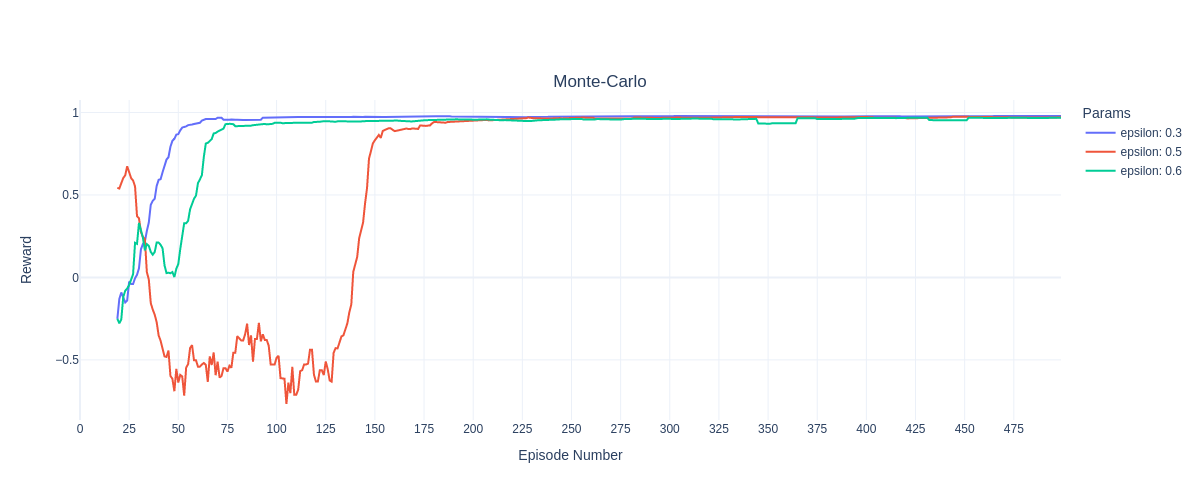

In [33]:
param_grid = {'epsilon': [0.3, 0.5, 0.6]}
              
rewards_list, best_params, min_episode = grid_search(param_grid=param_grid, func=monte_carlo, env=MazeEnvCast15x15)
viz_rewards(rewards_list=rewards_list, title='Monte-Carlo')

**Convergence**

We can see Monte-Carlo with epsilon 0.5 converged and is stable at ~200 episodes.

In [ ]:
π = monte_carlo(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15), epsilon=0.5, max_episodes=200)

In [ ]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))

Now we will see what happen halfway (with only half of the episodes)

In [36]:
π = monte_carlo(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15), epsilon=0.5, max_episodes=100)

Episode 100, episodes average len: 509

In [ ]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))

---

### SARSA 15X15

In [ ]:
def epsilon_greedy_policy(Q, state, actions, epsilon):
    """Choose an action according to an epsilon-greedy policy.
    
    Parameters
    ----------
    Q : array-like
        A 2D array representing the action-value function.
    state : tuple
        The current state.
    actions : array-like
        A list of possible actions.
    epsilon : float
        The probability of choosing a random action.
    
    Returns
    -------
    action : int
        The chosen action.
    
    """

    action = np.argmax(Q[state])
    if np.random.random() < epsilon:
        action = random.choices(np.delete(actions, action))[0]
    
    return action

In [ ]:
def sarsa(env, alpha=0.7, discount=0.9, epsilon=0.1, epsilon_decay=True, epsilon_decay_coef=0.99, decay_delta=1, max_episodes=500, n_iters=10_000,  display_rewards=False, return_heatmap=False):
    """
    Applies the SARSA algorithm to the given environment.
    
    Parameters
    ----------
    env : gym.Env
        The environment to apply the SARSA algorithm to.
    alpha : float, default=0.7
        The learning rate to use in the SARSA update rule.
    discount : float, default=0.9
        The discount factor to use in the SARSA update rule.
    epsilon : float, default=0.3
        The probability of choosing a random action in the epsilon-greedy policy.
    epsilon_decay : bool, default=True
        Whether or not to decay epsilon over time.
    epsilon_decay_coef : float, default=0.99
        The coefficient by which to decay epsilon if epsilon_decay is True.
    decay_delta : int, default=20
        The number of episodes after which to decay epsilon.
    max_episodes : int, default=500
        The maximum number of episodes to run the SARSA algorithm for.
    n_iters : int, default=10_000
        The maximum number of iterations to run the SARSA algorithm for each episode.
    display_rewards : bool, default=False
        Whether or not to return the rewards for each episode.
    return_heatmap : bool, default=False
        Whether or not to return a heatmap of the number of visits to each state.
    
    Returns
    -------
    Q : dict
        The action-value function learned by the SARSA algorithm.
    rewards : list
        The rewards for each episode if display_rewards is True.
    heatmap_state_visists : numpy.ndarray
        A heatmap of the number of visits to each state if return_heatmap is True.
    """
    
    rows = env.observation_space().high[0] + 1
    cols = env.observation_space().high[1] + 1
    n_actions = env.action_space().n
    actions = np.arange(n_actions)

    Q = {(i, j): np.zeros(n_actions) for j in range(cols) for i in range(rows)}

    heatmap_state_visists = np.zeros(shape=(rows, cols))  # For visualisation purposes
    rewards = []
    for episode in np.arange(max_episodes) + 1:
      distinct_state_status = np.zeros(shape=(rows, cols))
      total_reward = 0 

      state = env.reset()
      action = epsilon_greedy_policy(Q=Q, state=state, actions=actions, epsilon=epsilon)

      done = False
      for _ in range(n_iters):
        next_state, reward, done, info = env.step(action, state)
        next_action = epsilon_greedy_policy(Q=Q, state=next_state, actions=actions, epsilon=epsilon)

        total_reward += reward
        distinct_state_status[int(state[0]), int(state[1])] +=  1

        # Q-learning update rule:
        Q[state][action] = Q[state][action] + alpha * (reward + discount * Q[next_state][next_action] - Q[state][action])

        state, action = next_state, next_action

        if done:
          break

      print(f'\rEpisode {episode}', end='')
      if epsilon_decay and np.mod(episode, decay_delta) == 0:
        epsilon *= epsilon_decay_coef
    
      rewards.append(total_reward)
      heatmap_state_visists += np.minimum(distinct_state_status, np.ones(shape=(rows, cols)))

    if return_heatmap:
      return Q, rewards, heatmap_state_visists

    if display_rewards:
      return Q, rewards

    return Q

In [40]:
π = sarsa(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))

Episode 500

In [41]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))


 {'alpha': 0.1}
Episode 500
 {'alpha': 0.3}
Episode 500
 {'alpha': 0.7}
Episode 500

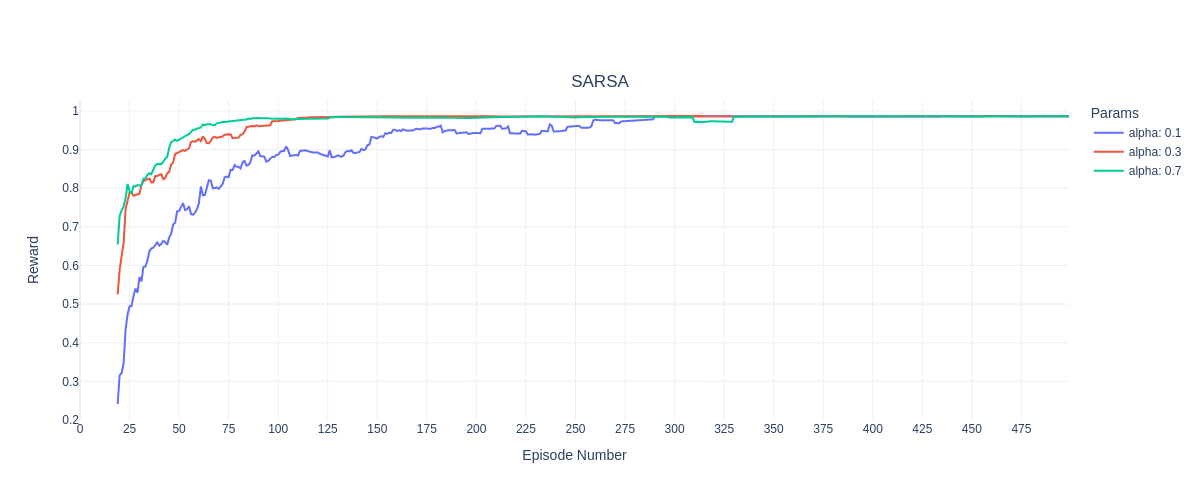

In [42]:
param_grid = {'alpha': [0.1, 0.3, 0.7]}
              
rewards_list, best_params, min_episode = grid_search(param_grid=param_grid, func=sarsa, env=MazeEnvCast15x15)
viz_rewards(rewards_list=rewards_list, title='SARSA')

**Convergence**

We can see SARSA with alpha 0.7 converged and is stable at ~100 episodes.

In [ ]:
π = sarsa(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15), alpha=0.7, max_episodes=100)

In [ ]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))

Now we will see what happen halfway (with only half of the episodes)

In [ ]:
π = sarsa(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15), alpha=0.7, max_episodes=50)

In [ ]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))

---

### Q-Learning 15X15

In [ ]:
def Q_learning(env, alpha=0.5, discount=0.9, epsilon=0.1, epsilon_decay=True, epsilon_decay_coef=0.99, decay_delta=20, max_episodes=500, n_iters=10_000, display_rewards=False, return_heatmap=False):
    """
    Applies Q-learning to find the optimal policy for the given environment.
    
    Parameters
    ----------
    env : gym.Env
        An OpenAI gym environment.
    alpha : float, optional
        The learning rate for the Q-learning update rule.
    discount : float, optional
        The discount factor for the Q-learning update rule.
    epsilon : float, optional
        The probability of taking a random action in the epsilon-greedy policy.
    epsilon_decay : bool, optional
        Whether to decay the value of epsilon over time.
    epsilon_decay_coef : float, optional
        The coefficient by which to decay epsilon. Only used if `epsilon_decay` is True.
    decay_delta : int, optional
        The number of episodes after which to decay epsilon. Only used if `epsilon_decay` is True.
    max_episodes : int, optional
        The maximum number of episodes to run the Q-learning algorithm.
    n_iters : int, optional
        The maximum number of iterations to run within each episode.
    display_rewards : bool, optional
        Whether to return the list of rewards per episode.
    return_heatmap : bool, optional
        Whether to return a heatmap of state visits.
    
    Returns
    -------
    Q : dict[tuple, numpy.ndarray]
        A dictionary mapping states (tuples of integers) to arrays of Q-values for each action.
    rewards : list[float]
        A list of rewards per episode, if `display_rewards` is True.
    heatmap_state_visits : numpy.ndarray
        A heatmap of state visits, if `return_heatmap` is True.
    """
    rows = env.observation_space().high[0] + 1
    cols = env.observation_space().high[1] + 1
    n_actions = env.action_space().n

    Q = {(i, j): np.zeros(n_actions) for j in range(cols) for i in range(rows)}

    heatmap_state_visists = np.zeros(shape=(rows, cols))  # For visualisation purposes
    rewards = []
    for episode in np.arange(max_episodes) + 1:
      total_reward = 0
      distinct_state_status = np.zeros(shape=(rows, cols))
      
      state = env.reset()
      done = False
      for _ in range(n_iters):

        best_action = np.argmax(Q[state])
        policy = [1 - epsilon + (epsilon / n_actions) if move == best_action else epsilon / n_actions  for move in range(n_actions)]
        action = np.random.choice(range(n_actions), p=policy)

        distinct_state_status[int(state[0]), int(state[1])] +=  1

        next_state, reward, done, info = env.step(action, state)
        total_reward += reward

        # Q-learning update rule:
        Q[state][action] = Q[state][action] + alpha * (reward + discount * max(Q[next_state]) - Q[state][action])
        state = next_state

        if done:
          break

      rewards.append(total_reward)
      print(f'\rEpisode {episode}', end='')
      
      if epsilon_decay and np.mod(episode, decay_delta) == 0:
        epsilon *= epsilon_decay_coef

      heatmap_state_visists += np.minimum(distinct_state_status, np.ones(shape=(rows, cols)))

    if return_heatmap:
      return Q, rewards, heatmap_state_visists
      
    if display_rewards:
      return Q, rewards

    return Q

In [ ]:
π = Q_learning(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))

In [49]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))

In [ ]:
param_grid = {'epsilon': [0.3, 0.5],
              'discount': [0.9, 0.95]}
              
rewards_list, best_params, min_episode = grid_search(param_grid=param_grid, func=Q_learning, env=MazeEnvCast15x15)
viz_rewards(rewards_list=rewards_list, title='Q-Learning')

**Convergence**

We can see Q-Learning with epsilon 0.3 and discount of 0.95 converged and is stable at ~150 episodes.

In [ ]:
π = Q_learning(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15), epsilon=0.3, discount=0.95, max_episodes=150)

In [52]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))

Now we will see what happen halfway (with only half of the episodes)

In [ ]:
π = Q_learning(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15), epsilon=0.3, discount=0.95, max_episodes=75)

In [ ]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast15x15))

---

## EX3

### Dynamic Programming 25X25

In [93]:
new_π, V = policy_iteration(env=MazeEnvCast25x25, discount=0.9)

In [94]:
create_video(π=new_π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25))

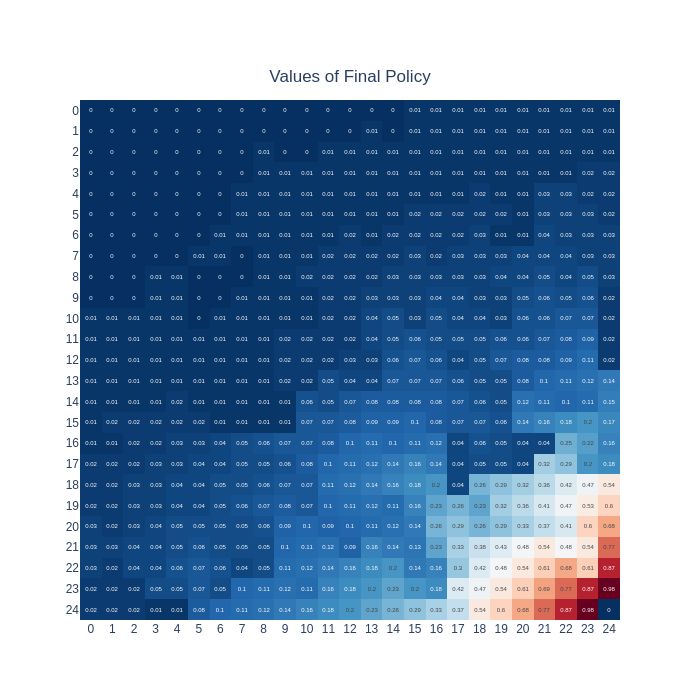

In [95]:
viz_heatmap(matrix=V.round(2), title='Values of Final Policy')

---

### Monte-Carlo 25X25

We ran some experiments with Monte Carlo but it didn't converge so we decided to drop it. 

---

### SARSA 25X25

In [96]:
π = sarsa(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25), discount=0.9, alpha=0.7, epsilon=0.1)

Episode 500

In [97]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25))

---

### Q-Learning 25X25

In [98]:
π = Q_learning(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25))

Episode 500

In [99]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25))

---

### Experiments

#### Experiment: Q-Learning

Gridsearch for optimal params Q-Learning

In [100]:
param_grid = {'alpha': [0.3, 0.7],
              'discount': [0.9, 0.95],
              'epsilon': [0.1, 0.3]}
              

rewards_list, best_params_Q, min_episode_Q = grid_search(param_grid=param_grid, func=Q_learning, env=MazeEnvCast25x25)


 {'alpha': 0.3, 'discount': 0.9, 'epsilon': 0.1}
Episode 500
 {'alpha': 0.3, 'discount': 0.9, 'epsilon': 0.3}
Episode 500
 {'alpha': 0.3, 'discount': 0.95, 'epsilon': 0.1}
Episode 500
 {'alpha': 0.3, 'discount': 0.95, 'epsilon': 0.3}
Episode 500
 {'alpha': 0.7, 'discount': 0.9, 'epsilon': 0.1}
Episode 500
 {'alpha': 0.7, 'discount': 0.9, 'epsilon': 0.3}
Episode 500
 {'alpha': 0.7, 'discount': 0.95, 'epsilon': 0.1}
Episode 500
 {'alpha': 0.7, 'discount': 0.95, 'epsilon': 0.3}
Episode 500

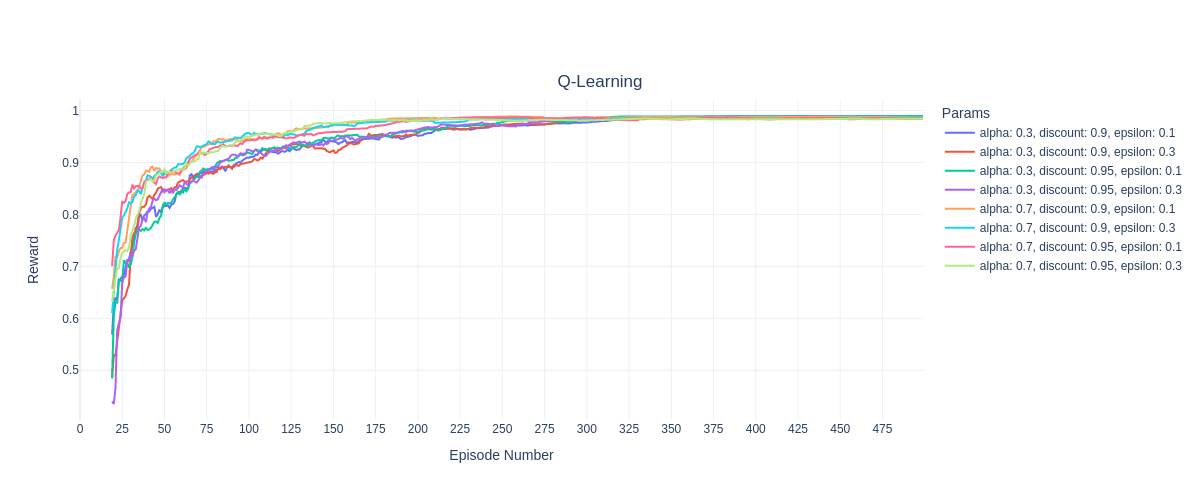

In [101]:
viz_rewards(rewards_list=rewards_list, title='Q-Learning')

Run Q-Learning with best params

In [102]:
best_params_Q

{'alpha': 0.7, 'discount': 0.9, 'epsilon': 0.1}

In [103]:
π, rewards, heatmap_state_visits = Q_learning(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25), max_episodes=min_episode_Q, return_heatmap=True, **best_params_Q)

Episode 189

In [104]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25))

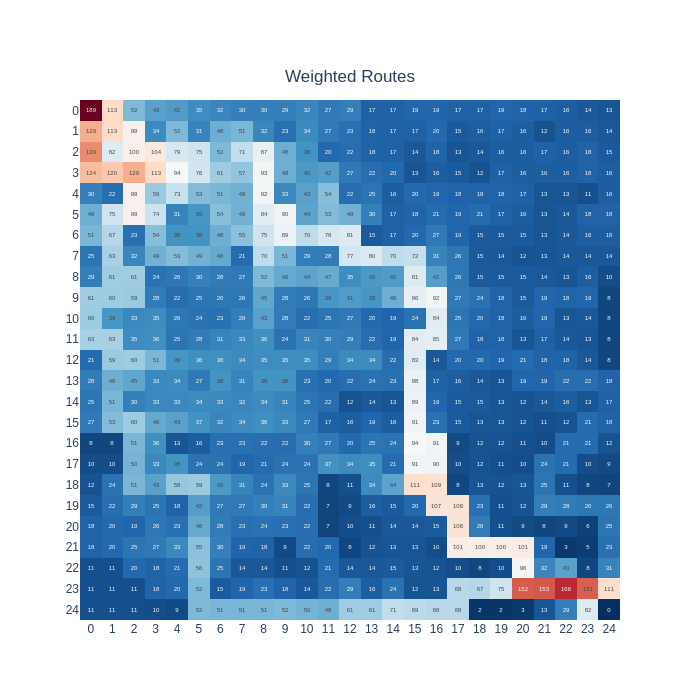

In [105]:
viz_heatmap(matrix=heatmap_state_visits, title='Weighted Routes', name='Distinct Visits')

Planted Rewards

We can see Q-Learning explores the bottom left of the Maze,
If we block one of the main paths to this area, it may help the algorithm to converge faster.

In [106]:
planted_rewards_config_Q = {'negative': {'position': (2, 4), 'reward': -1},
                            'positive': {'position': (24, 24), 'reward': 0.1}}

π, rewards, heatmap_state_visits = Q_learning(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25, planted_rewards_config=planted_rewards_config_Q),
                                              max_episodes=min_episode_Q, return_heatmap=True, **best_params_Q)

Episode 189

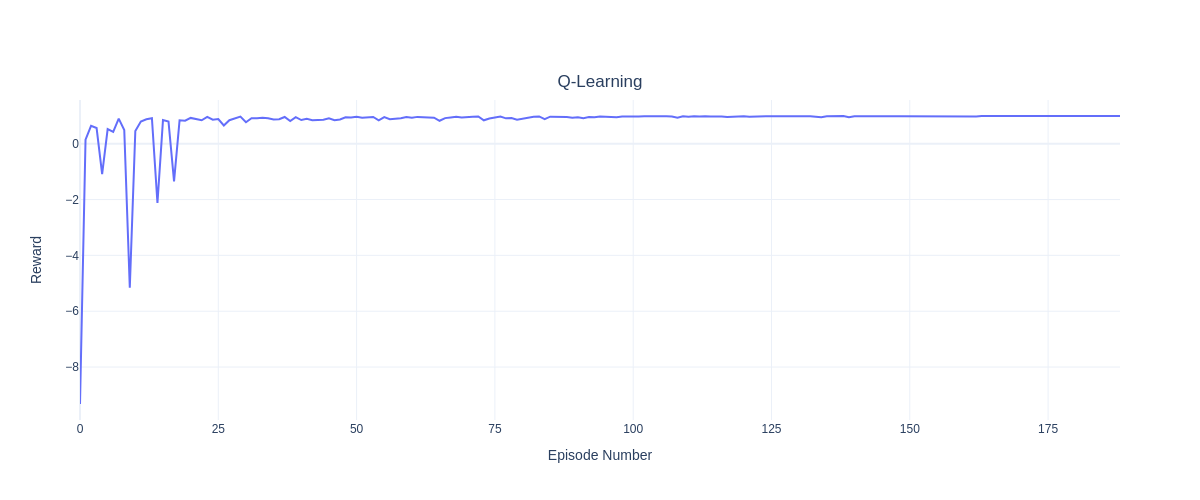

In [107]:
rewards_list = [(best_params_Q, rewards)]

viz_rewards(rewards_list=rewards_list, title='Q-Learning', rolling=False)

In [108]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25))

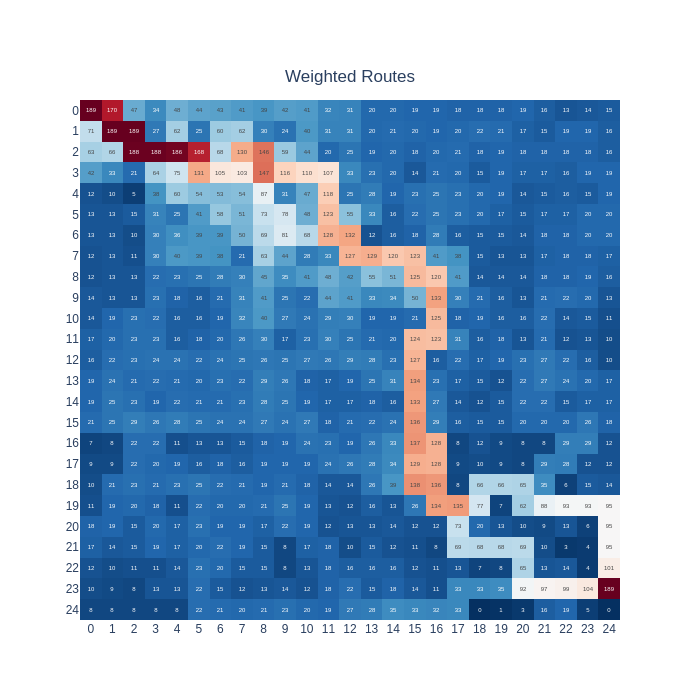

In [109]:
viz_heatmap(matrix=heatmap_state_visits, title='Weighted Routes', name='Distinct Visits')

We can reduce the number of episodes to ~200 using the planted rewards

In [110]:
π, rewards_Q, heatmap_state_visits = Q_learning(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25, planted_rewards_config=planted_rewards_config_Q),
                                                max_episodes=200, return_heatmap=True, **best_params_Q)

Episode 200

In [111]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25))

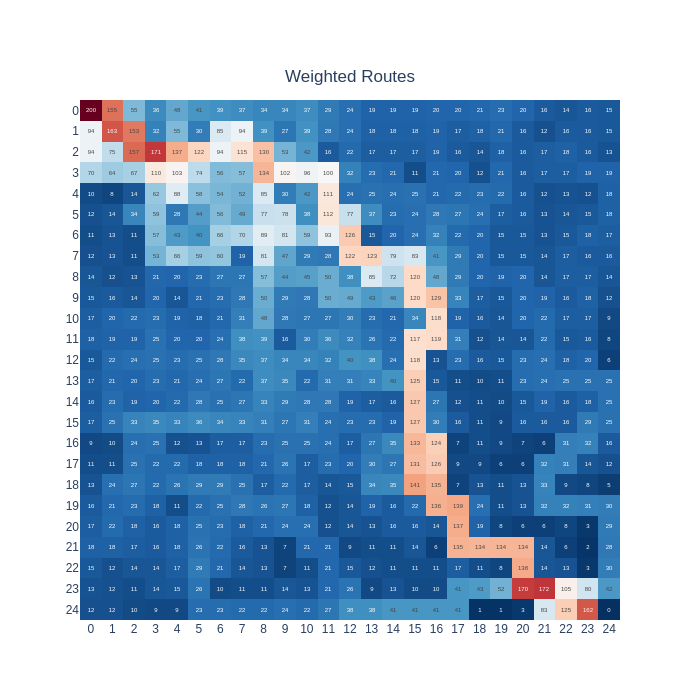

In [112]:
viz_heatmap(matrix=heatmap_state_visits, title='Weighted Routes', name='Distinct Visits')

#### Experiments: SARSA

Gridsearch for optimal params SARSA

In [113]:
param_grid = {'alpha': [0.7, 0.9],
              'discount': [0.9, 0.95],
              'epsilon': [0.1, 0.3]}
              

rewards_list, best_params_sarsa, min_episode_sarsa = grid_search(param_grid=param_grid, func=sarsa, env=MazeEnvCast25x25, reward_threshold=0.989)


 {'alpha': 0.7, 'discount': 0.9, 'epsilon': 0.1}
Episode 500
 {'alpha': 0.7, 'discount': 0.9, 'epsilon': 0.3}
Episode 500
 {'alpha': 0.7, 'discount': 0.95, 'epsilon': 0.1}
Episode 500
 {'alpha': 0.7, 'discount': 0.95, 'epsilon': 0.3}
Episode 500
 {'alpha': 0.9, 'discount': 0.9, 'epsilon': 0.1}
Episode 500
 {'alpha': 0.9, 'discount': 0.9, 'epsilon': 0.3}
Episode 500
 {'alpha': 0.9, 'discount': 0.95, 'epsilon': 0.1}
Episode 500
 {'alpha': 0.9, 'discount': 0.95, 'epsilon': 0.3}
Episode 500

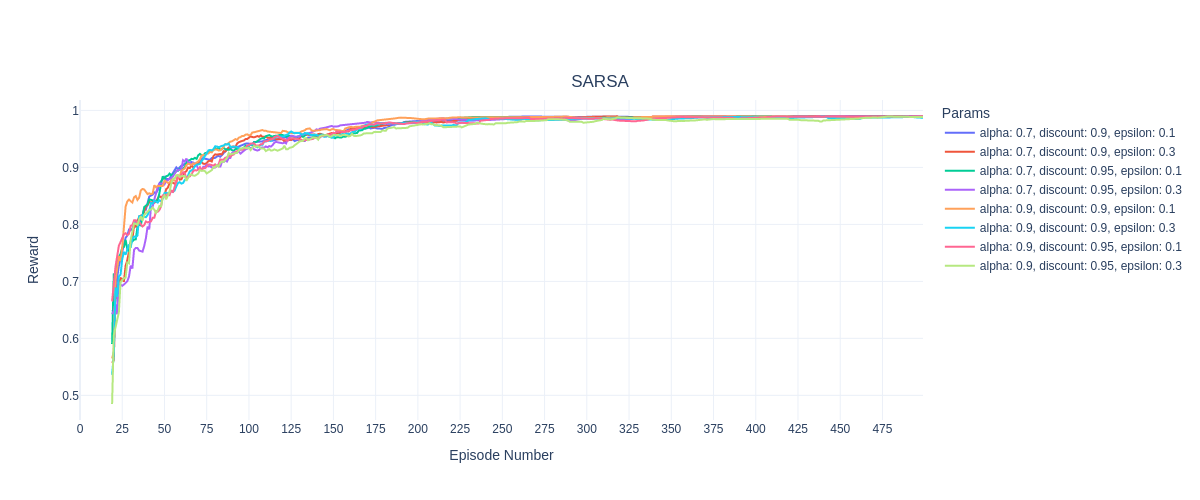

In [114]:
viz_rewards(rewards_list=rewards_list, title='SARSA')

Run SARSA with best params

In [115]:
best_params_sarsa

{'alpha': 0.7, 'discount': 0.9, 'epsilon': 0.1}

In [116]:
π, rewards, heatmap_state_visits = sarsa(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25), max_episodes=min_episode_sarsa, return_heatmap=True, **best_params_sarsa)

Episode 356

In [117]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25))

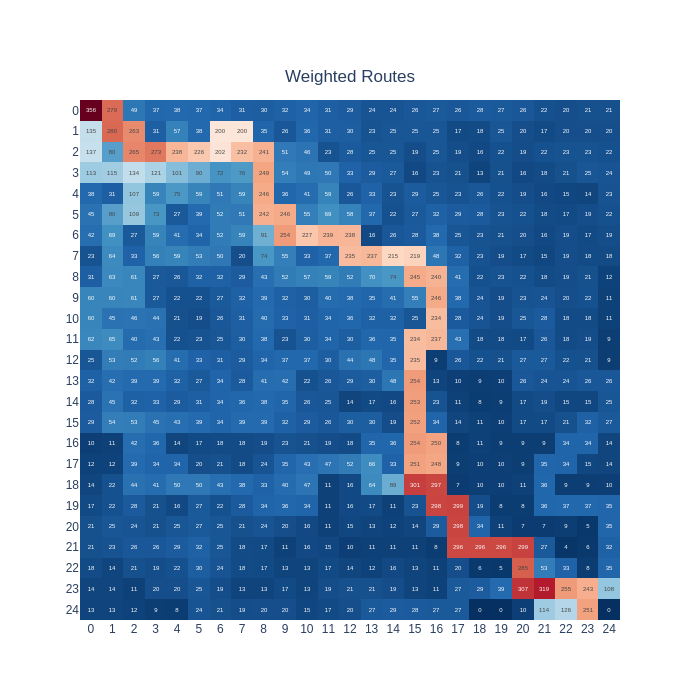

In [118]:
viz_heatmap(matrix=heatmap_state_visits, title='Weighted Routes', name='Distinct Visits')

Planted Rewards

We can see SARSA explores the upper part of the Maze (close to the initial area),
If we block one of the main paths to this area, it may help the algorithm to converge faster.

In [119]:
planted_rewards_config_sarsa = {'negative': {'position': (1, 0), 'reward': -1},
                                'positive': {'position': (24, 24), 'reward': 1}}

π, rewards, heatmap_state_visits = sarsa(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25, planted_rewards_config=planted_rewards_config_sarsa),
                                              max_episodes=min_episode_sarsa, return_heatmap=True, **best_params_sarsa)

Episode 356

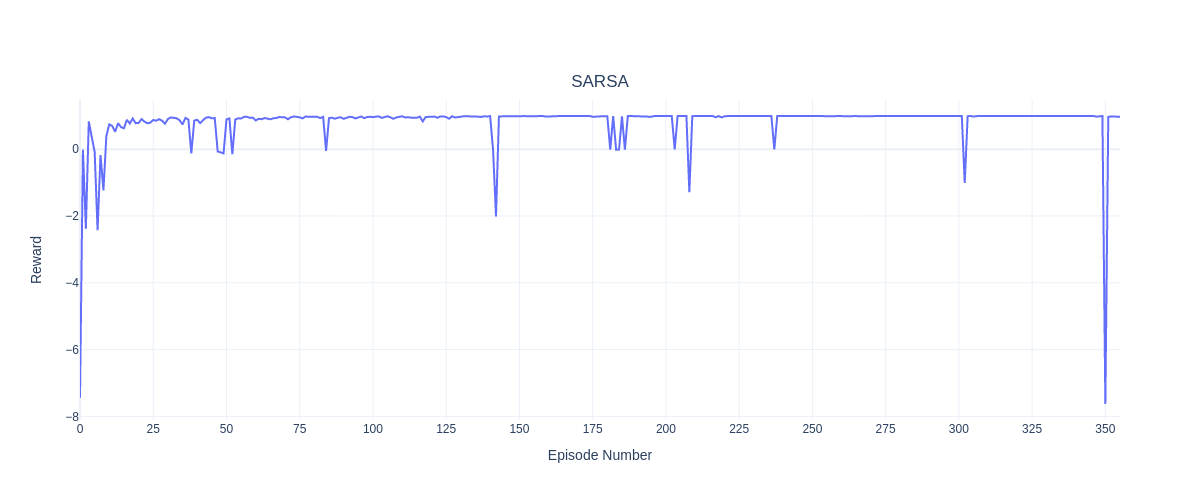

In [120]:
rewards_list = [(best_params_sarsa, rewards)]

viz_rewards(rewards_list=rewards_list, title='SARSA', rolling=False)

In [121]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25))

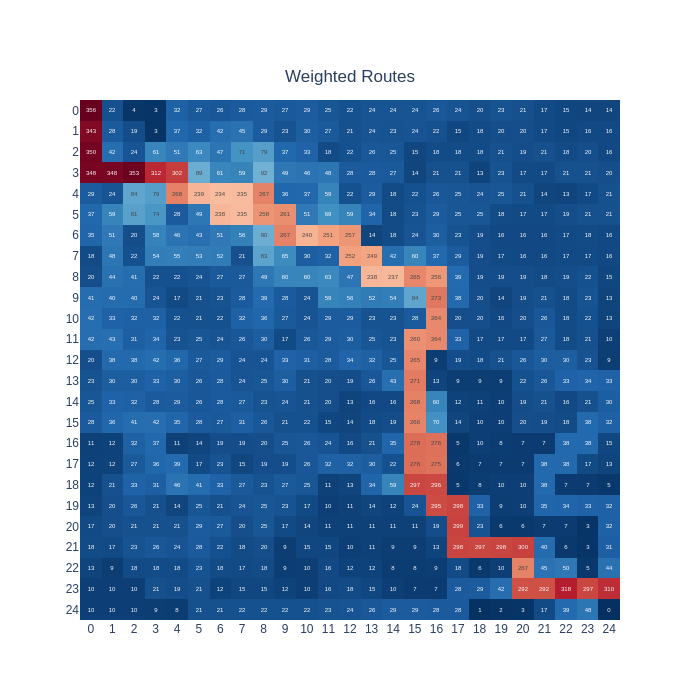

In [122]:
viz_heatmap(matrix=heatmap_state_visits, title='Weighted Routes', name='Distinct Visits')

We can reduce the number of episodes to ~200 using the planted rewards

In [123]:
π, rewards_sarsa, heatmap_state_visits = sarsa(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25, planted_rewards_config=planted_rewards_config_sarsa),
                                               max_episodes=200, return_heatmap=True, **best_params_sarsa)

Episode 200

In [124]:
create_video(π=π, env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25))

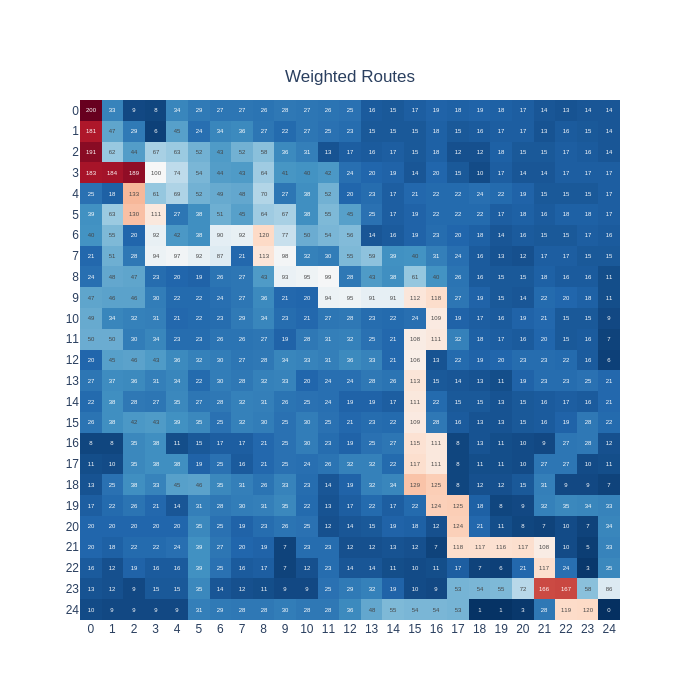

In [125]:
viz_heatmap(matrix=heatmap_state_visits, title='Weighted Routes', name='Distinct Visits')

---

#### Conclusions

Runtime Dynamic Programming

In [126]:
%%time

new_π, V = policy_iteration(env=MazeEnvCast25x25, discount=0.9)

CPU times: user 14.9 s, sys: 54.6 ms, total: 14.9 s
Wall time: 15.2 s


Runtime Q-Learning

In [127]:
%%time

π, rewards, heatmap_state_visits = Q_learning(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25, planted_rewards_config=planted_rewards_config_Q),
                                              max_episodes=200, return_heatmap=True, **best_params_Q)

Episode 200CPU times: user 15.7 s, sys: 103 ms, total: 15.8 s
Wall time: 16.2 s


Runtime SARSA

In [128]:
%%time

π, rewards, heatmap_state_visits = sarsa(env=EnvWrapper(config=dict(stochastic=0.1), env=MazeEnvCast25x25, planted_rewards_config=planted_rewards_config_sarsa),
                                         max_episodes=200, return_heatmap=True, **best_params_sarsa)

Episode 200CPU times: user 8.51 s, sys: 101 ms, total: 8.61 s
Wall time: 8.91 s


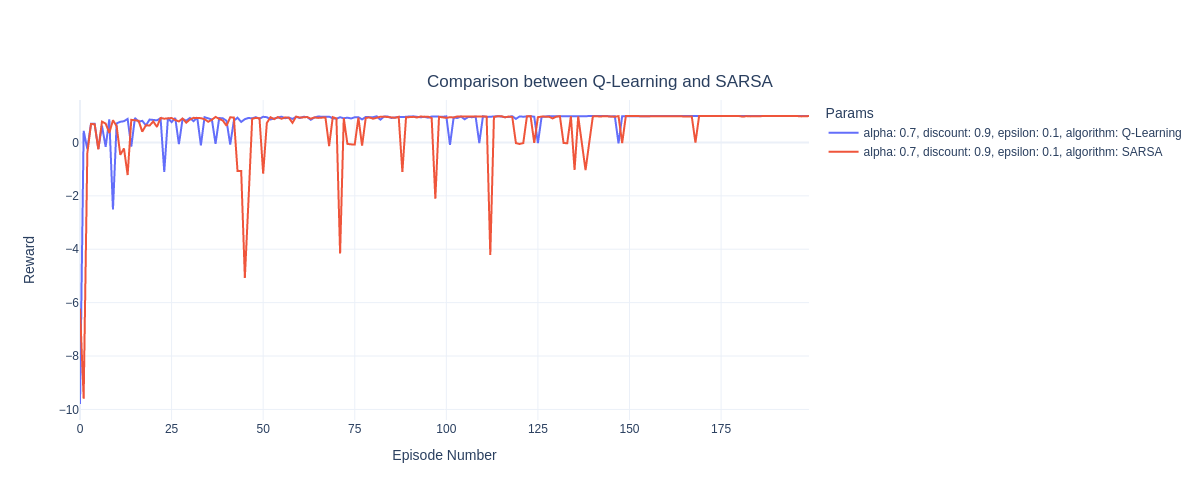

In [129]:
best_params_Q['algorithm'] = 'Q-Learning'
best_params_sarsa['algorithm'] = 'SARSA'

rewards_list = [(best_params_Q, rewards_Q),
                (best_params_sarsa, rewards_sarsa)]

viz_rewards(rewards_list=rewards_list, title='Comparison between Q-Learning and SARSA', rolling=False)

---